In [1]:
from __future__ import print_function
import openturns as ot
#from openturns.viewer import View
import time

In [2]:
# First, create a mesh
interval = ot.Interval([-6.0]*2, [6.0]*2)
f = ot.SymbolicFunction(['x0', 'x1'], ['1.0 - (1.2 + cos(pi_ * x0))^2 - (1.2 + cos(pi_ * x1))^2'])
level = 0.0
domain = ot.LevelSet(f, ot.LessOrEqual(), level)
discretization = [71, 71]
# To have a more symmetric mesh
ot.ResourceMap.SetAsBool('IntervalMesher-UseDiamond', True)
mesh = ot.LevelSetMesher(discretization).build(domain, interval)
#mesh.exportToVTKFile('domain.vtk')

In [3]:
# Second, a model with functional output
dim = 4
class FUNC(ot.OpenTURNSPythonFunction):
    def __init__(self, mesh):
        super(FUNC, self).__init__(dim, mesh.getVerticesNumber())
        self.mesh_ = mesh
        self.nc_ = 0

    def _exec(self, X):
        self.nc_ += 1
        #print('nc=', self.nc_, 'X=', X)
        xc0 = 1.0 * X[0]
        xc1 = 1.2 * X[1]
        xpc0 = 0.8 * X[2]
        xpc1 = 0.6 * X[3]
        func = ot.SymbolicFunction(['x0', 'x1'], ['exp(-0.25*((x0-(' + str(xc0) + '))^2+(x1-(' + str(xc1) + '))^2))+exp(-0.25*((x0-(' + str(xpc0) + '))^2+(x1-(' + str(xpc1) + '))^2))'])
        values = func(self.mesh_.getVertices())
        # Here we convert the sample of values into a single vector
        return [values[i, 0] for i in range(values.getSize())]

F = FUNC(mesh)
model = ot.Function(F)

In [4]:
# Sobol indices using PCE
# Input distribution
distribution = ot.Normal(dim)
# Here we use a tensor-product enumerate function (100.0 ~ inf)
# because we use a Gauss product integration method (low dimension here)
enumerateFunction = ot.HyperbolicEnumerateFunction(dim, 100.0)
basis = ot.OrthogonalProductPolynomialFactory([ot.HermiteFactory()]*dim, enumerateFunction)
marginalDegree = 4

totalSize = marginalDegree**dim
print('basis total size=', totalSize)
print('input total size=', (marginalDegree+1)**dim)
adaptive = ot.FixedStrategy(basis, totalSize)

# Exact projection using Gauss Legendre integration
projection = ot.IntegrationStrategy(ot.GaussProductExperiment(distribution, [marginalDegree+1]*dim))

# PCE
algo = ot.FunctionalChaosAlgorithm(model, distribution, adaptive, projection)
t0 = time.time()
#ot.Log.Show(ot.Log.INFO)
algo.run()
print('t=', time.time() - t0, 's')

basis total size= 256
input total size= 625
t= 33.61125159263611 s


In [5]:
# Post-processing
vector = ot.FunctionalChaosSobolIndices(algo.getResult())

graphs=[]
# Field of Sobol indices
for i in range(dim):
    #print('i=', i)
    sobol = ot.Field(mesh, [[vector.getSobolIndex(i, j)] for j in range(mesh.getVerticesNumber())])
    #sobol.exportToVTKFile('Sobol_' + str(i) + '_I_field.vtk')
    graph = sobol.draw()
    graph.setTitle('Sobol ' + str(i))
    graphs.append(graph)
    #view = View(graph, pixelsize=(600,610))
    #view.save('Sobol_' + str(i) + '_I_field.png')
    #view.show()

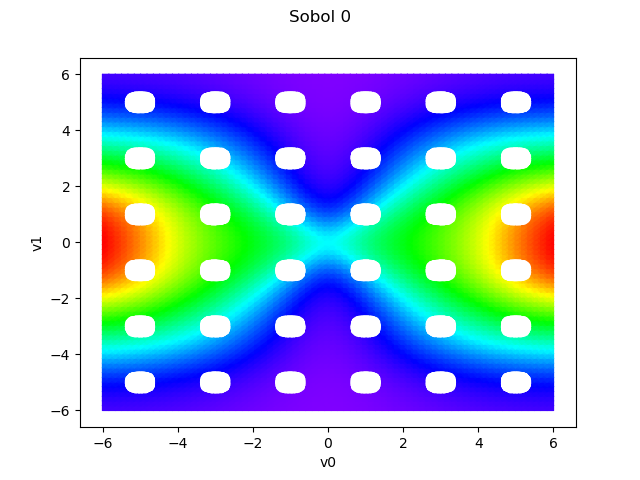

In [6]:
graphs[0]

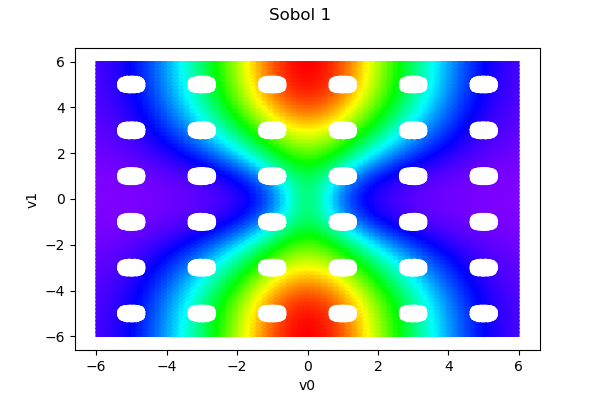

In [7]:
graphs[1]

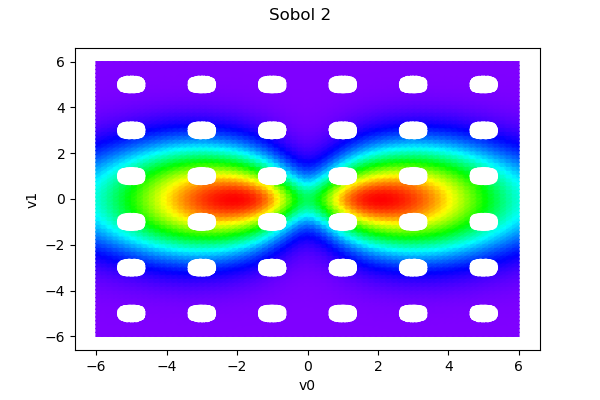

In [9]:
graphs[2]

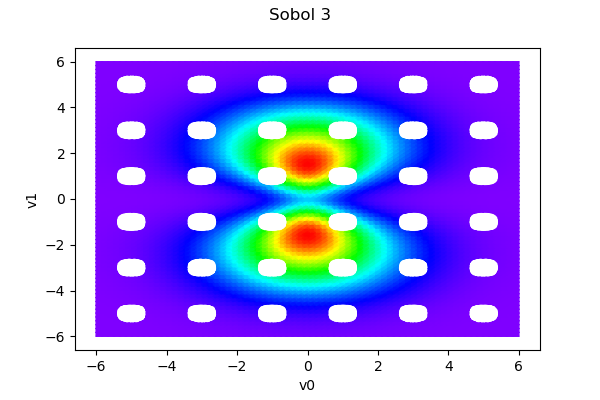

In [8]:
graphs[3]